# Nav Sensor Demo 

In [8]:
import pynq
from pynq.overlays.base import BaseOverlay
from ctypes import *
import time
import numpy as np

ol = BaseOverlay("base.bit")
#print(ol.ip_dict)

In [9]:
%%microblaze ol.PMODA

#include <spi.h>
#include <stdint.h>
#include <pyprintf.h>
#include <unistd.h>

#define CS_A_PIN	0
#define CS_ALT_PIN	5
#define CS_M_PIN	6
#define MOSI_PIN	1
#define MISO_PIN	2
#define CLK_PIN	3

#define BUFF_SIZE	7


#define ACC_X_L_ADDR     0x28
#define MAG_X_L_ADDR     0x28
#define GYRO_X_L_ADDR    0x18
#define ALT_X_L_ADDR     0x28

#define CTRL_REG6_XL_ADDR    0x20

#define X_DIR_SEL       0x01
#define Y_DIR_SEL       0x02
#define Z_DIR_SEL       0x03

#define READ_CFG       1<<7 //bit 7 high
#define WRITE_CFG      0x7F //bit 7 low
#define MS_CFG         0xC0 //11000000

#define STATE_ON       0x01
#define STATE_OFF      0x00

#define CTRL_REG5_XL   0x1F
#define CTRL_REG6_XL   0x20
#define CTRL_REG4      0x1E

#define CTRL_REG1_M    0x20
#define CTRL_REG2_M    0x21
#define CTRL_REG3_M    0x22
#define CTRL_REG4_M    0x23
#define CTRL_REG5_M    0x24

#define CTRL_REG1_G    0x10
#define CTRL_REG2_G    0x11
#define CTRL_REG3_G    0x12

#define CTRL_REG1_ALT 0x20
#define CTRL_REG2_ALT 0x21
#define CTRL_REG4_ALT 0x23

#define GYRO_WHO_AM_I  0x0F

//Parameter dps range : +/- 245dps
#define NAV_GYRO_PAR_G_245DPS 0
//Parameter dps range : +/- 500dps
#define NAV_GYRO_PAR_G_500DPS 1
//Parameter dps range : +/- 2kdps
#define NAV_GYRO_PAR_G_2kDPS 3

//Parameter G range : +/- 2g
#define NAV_ACL_PAR_XL_2G 0
//Parameter G range : +/- 4g
#define NAV_ACL_PAR_XL_4G 2 
//Parameter G range : +/- 8g
#define NAV_ACL_PAR_XL_8G 3
//Parameter G range : +/- 16g
#define NAV_ACL_PAR_XL_16G 1

int SPI_Write(uint8_t addr, uint8_t val, uint8_t CS)
{
    uint8_t tx_buff[BUFF_SIZE] = {0};
    uint8_t rx_buff[BUFF_SIZE] = {0};
    
    tx_buff[0] = addr & WRITE_CFG;
    tx_buff[1] = val;
    
    spi nav = spi_open(CLK_PIN, MISO_PIN, MOSI_PIN, CS);
    
    spi_transfer(nav, (char*)tx_buff, (char*)rx_buff, 2);
    
    spi_close(nav);
    
    return 0;
}

uint8_t SPI_Read(uint8_t addr, uint8_t CS)
{
    uint8_t tx_buff[BUFF_SIZE] = {0};
    uint8_t rx_buff[BUFF_SIZE] = {0};
    
    tx_buff[0] = addr | READ_CFG;   
    
    spi nav = spi_open(CLK_PIN, MISO_PIN, MOSI_PIN, CS);
    
    spi_transfer(nav, (char*)tx_buff, (char*)rx_buff, 2);
    
    spi_close(nav);
    
    return rx_buff[1];
}

int Nav_Acc_Gyro_Pwr(uint8_t state)
{
    uint8_t temp_val = 0x00;
    
    if(state == STATE_ON)
    {  
        //enable acc output
        SPI_Write(CTRL_REG5_XL, 0x38, CS_A_PIN); //00111000
        //pyprintf("CTRL_REG5_XL, %x\r\n", SPI_Read(CTRL_REG5_XL, CS_A_PIN));
        //set odr rate 952Hz of acc
         SPI_Write(CTRL_REG6_XL, 0xC0, CS_A_PIN); //11000000
        //pyprintf("CTRL_REG6_XL, %x\r\n", SPI_Read(CTRL_REG6_XL, CS_A_PIN));
        //set odr rate 14.9Hz of gyro
        SPI_Write(CTRL_REG1_G, 0xC0, CS_A_PIN); //11000000
        //pyprintf("CTRL_REG1_G, %x\r\n", SPI_Read(CTRL_REG1_G, CS_A_PIN));
        //enable gyro output
        SPI_Write(CTRL_REG4, 0x38, CS_A_PIN);//00111000
        //pyprintf("CTRL_REG4, %x\r\n", SPI_Read(CTRL_REG4, CS_A_PIN));

    }
    else
    {
        pyprintf("--ACC Power OFF--\r\n");
        SPI_Write(CTRL_REG5_XL, 0x00, CS_A_PIN); 
        SPI_Write(CTRL_REG6_XL, 0x00, CS_A_PIN);
        SPI_Write(CTRL_REG4, 0x00, CS_A_PIN);
        SPI_Write(CTRL_REG1_G, 0x00, CS_A_PIN);
    }
    return 0;
}

int Nav_Acc_Pwr(uint8_t state)
{
    uint8_t temp_val = 0x00;
    
    if(state == STATE_ON)
    {
        //enable all three axes
        //pyprintf("--ACC Power ON--\r\n");
        
        SPI_Write(CTRL_REG5_XL, 0x38, CS_A_PIN);
        //pyprintf("CTRL_REG5_XL: %x\r\n", SPI_Read(CTRL_REG5_XL, CS_A_PIN));
        
        //set 10Hz odr for accelerometer use 0x20; 0010 0000
        //952Hz odr for accelerometer use 0xC0; 1100 0000
        SPI_Write(CTRL_REG6_XL, 0x20, CS_A_PIN);
        //pyprintf("CTRL_REG6_XL: %x\r\n", SPI_Read(CTRL_REG6_XL, CS_A_PIN));
    }
    else
    {
        pyprintf("--ACC Power OFF--\r\n");
        
        SPI_Write(CTRL_REG5_XL, 0x00, CS_A_PIN);
        //pyprintf("CTRL_REG5_XL: %x\r\n", SPI_Read(CTRL_REG5_XL, CS_A_PIN));
        SPI_Write(CTRL_REG6_XL, 0x00, CS_A_PIN);
        //pyprintf("CTRL_REG6_XL: %x\r\n", SPI_Read(CTRL_REG6_XL, CS_A_PIN));
        
    }
    return 0;
}

int Nav_Alt_Pwr(uint8_t state)
{
    uint8_t temp_val = 0x00;
    
    if(state == STATE_ON)
    {
        
        //pyprintf("--ALT Power ON--\r\n");
        
        //clean start
        SPI_Write(CTRL_REG1_ALT, 0x00, CS_ALT_PIN);
        //pyprintf("CTRL_REG1_ALT: %x\r\n", SPI_Read(CTRL_REG1_ALT, CS_ALT_PIN));
        usleep(5000);
        //set 7Hz odr for barometer
        SPI_Write(CTRL_REG1_ALT, 0xA4, CS_ALT_PIN);
        //pyprintf("CTRL_REG1_ALT: %x\r\n", SPI_Read(CTRL_REG1_ALT, CS_ALT_PIN));
        usleep(5000);
        //increment address duringmutliple byte access disabled
        SPI_Write(CTRL_REG2_ALT, 0x00, CS_ALT_PIN);
        usleep(5000);
        //no modification to interrupt sources
        SPI_Write(CTRL_REG4_ALT, 0x00, CS_ALT_PIN);
        usleep(5000);
    }
    else
    {
        pyprintf("--ALT Power OFF--\r\n");
        
        SPI_Write(CTRL_REG1_ALT, 0x00, CS_ALT_PIN);
        //pyprintf("CTRL_REG1_ALT: %x\r\n", SPI_Read(CTRL_REG1_ALT, CS_ALT_PIN));

    }
    return 0;
}

int Nav_Mag_Pwr(uint8_t state)
{
    if(state == STATE_ON)
    {
        //pyprintf("--MAG Power ON--\r\n");
        //set medium performance mode for x and y and 10Hz ODR for MAG, 
        SPI_Write(CTRL_REG1_M, 0x30, CS_M_PIN);
        //pyprintf("CTRL_REG1_M, %x\r\n", SPI_Read(CTRL_REG1_M, CS_M_PIN));
        
        //set scale to +-4Gauss
        SPI_Write(CTRL_REG2_M, 0x00, CS_M_PIN);
        //pyprintf("CTRL_REG2_M, %x\r\n", SPI_Read(CTRL_REG2_M, CS_M_PIN));
        
        //disable I2C and enable SPI read and write operations, 
        //set the operating mode to continuous conversion
        SPI_Write(CTRL_REG3_M, 0x00, CS_M_PIN);
        //pyprintf("CTRL_REG3_M, %x\r\n", SPI_Read(CTRL_REG3_M, CS_M_PIN));
        
        //set medium performance mode for z axis
        SPI_Write(CTRL_REG4_M, 0x04, CS_M_PIN);
        //pyprintf("CTRL_REG4_M, %x\r\n", SPI_Read(CTRL_REG4_M, CS_M_PIN));
        
        //continuous update of output registers
        SPI_Write(CTRL_REG5_M, 0x00, CS_M_PIN);
        //pyprintf("CTRL_REG5_M, %x\r\n", SPI_Read(CTRL_REG5_M, CS_M_PIN));
    }
    else
    {
        //pyprintf("--MAG Power OFF--\r\n");
        //power down the instrument
        SPI_Write(CTRL_REG3_M, 0x03, CS_M_PIN);
    }
}

int Nav_Gyro_GetData(uint8_t axis)
{
    uint8_t tx_buff[7] = {0};
    uint8_t rx_buff[7] = {0};
    int16_t gyro_x = 0;
    int16_t gyro_y = 0;
    int16_t gyro_z = 0;
    
    
    tx_buff[0] = GYRO_X_L_ADDR | READ_CFG;
    
    //see NAV_INST_AG (0b001) used in PmodNav.c as opposed to CS_A_PIN 0
    spi nav = spi_open(CLK_PIN, MISO_PIN, MOSI_PIN, CS_A_PIN);
    spi_transfer(nav, (char*)tx_buff, (char*)rx_buff, 7);
    spi_close(nav);
    
    // Combines the read values for each axis to obtain the 16-bits values
    gyro_x = ((int16_t) rx_buff[2]<<8) | rx_buff[1];
    gyro_y = ((int16_t) rx_buff[4]<<8) | rx_buff[3];
    gyro_z = ((int16_t) rx_buff[6]<<8) | rx_buff[5];
    
    //pyprintf("Nav_Gyro_GetData: x: %d\r\n", gyro_x);
    //pyprintf("Nav_Gyro_GetData: y: %d\r\n", gyro_y);
    //pyprintf("Nav_Gyro_GetData: z: %d\r\n", gyro_z);
    
    if(axis == X_DIR_SEL)
    {
        return gyro_x;
    }
    else if(axis == Y_DIR_SEL)
    {
        return gyro_y;
    }
    else 
    {
        return gyro_z;
    }
    return 0;
}
    
    

int Nav_Acc_GetData(uint8_t axis)
{
    uint8_t tx_buff[7] = {0};
    uint8_t rx_buff[7] = {0};
    int16_t acc_x = 0;
    int16_t acc_y = 0;
    int16_t acc_z = 0;
    
    tx_buff[0] = ACC_X_L_ADDR | READ_CFG;
    
    spi nav = spi_open(CLK_PIN, MISO_PIN, MOSI_PIN, CS_A_PIN);
    spi_transfer(nav, (char*)tx_buff, (char*)rx_buff, 7);
    spi_close(nav);
    
    acc_x = rx_buff[2]<<8 | rx_buff[1];
    acc_y = rx_buff[4]<<8 | rx_buff[3];
    acc_z = rx_buff[6]<<8 | rx_buff[5];
  
    if(axis == X_DIR_SEL)
    {
        return acc_x;
    }
    else if(axis == Y_DIR_SEL)
    {
        return acc_y;
    }
    else 
    {
        return acc_z;
    }
    return 0;
}

int Nav_Alt_GetData(void)
{
    int32_t dataPress = 0;
    uint8_t tx_buff[4] = {0};
    uint8_t rx_buff[4] = {0};
    
    uint8_t iPress_XL = 0;
    uint8_t iPress_H = 0;
    uint8_t iPress_L = 0;
    
    tx_buff[0] = ALT_X_L_ADDR | READ_CFG;
    
    spi nav = spi_open(CLK_PIN, MISO_PIN, MOSI_PIN, CS_ALT_PIN);
    spi_transfer(nav, (char*)tx_buff, (char*)rx_buff, 4);
    spi_close(nav);
    
    iPress_XL = rx_buff[1];
    iPress_L = rx_buff[2];
    iPress_H = rx_buff[3];
    
    dataPress = (iPress_H << 16) | (iPress_L << 8) | (iPress_XL);
    
    //continue on NAV_ReadPressurehPa()
    //here
    return dataPress;
}

int Nav_Mag_GetData(uint8_t axis)
{
    uint8_t tx_buff[7] = {0};
    uint8_t rx_buff[7] = {0}; 
    int16_t mag_x = 0;
    int16_t mag_y =0;
    int16_t mag_z =0;
    
    tx_buff[0] = MAG_X_L_ADDR | READ_CFG;
    tx_buff[0] = tx_buff[0] | MS_CFG;
    
    spi nav = spi_open(CLK_PIN, MISO_PIN, MOSI_PIN, CS_M_PIN);
    spi_transfer(nav, (char*)tx_buff, (char*)rx_buff, 7);
    spi_close(nav);
    
    mag_x = rx_buff[2]<<8 | rx_buff[1];
    mag_y = rx_buff[4]<<8 | rx_buff[3];
    mag_z = rx_buff[6]<<8 | rx_buff[5];
    
    if(axis == X_DIR_SEL)
    {
        return mag_x;
    }
    else if(axis == Y_DIR_SEL)
    {
        return mag_y;
    }
    else 
    {
        return mag_z;
    }
    return 0;
}
int simple_func()
{
    
    uint8_t tx_buff[7] = {0};
    uint8_t rx_buff[7] = {0};
    
    int16_t mag_x = 0;
    int16_t mag_y =0;
    int16_t mag_z =0;
    
    tx_buff[0] = GYRO_WHO_AM_I | READ_CFG;
    tx_buff[0] = tx_buff[0] | MS_CFG;
    
    spi nav = spi_open(CLK_PIN, MISO_PIN, MOSI_PIN, CS_A_PIN);
    
    spi_transfer(nav, (char*)tx_buff, (char*)rx_buff, 7);
    
    
    
    //out1 = spi_transfer();
}

float Nav_GetGRangeLSB(uint8_t bRangeG) 
{
    float gRangeLSB;
    //pyprintf("Executing NAV_GetGRangeLSB..\n");
    switch (bRangeG) 
    {
    case NAV_GYRO_PAR_G_245DPS:
        gRangeLSB = 0.00875;
        //pyprintf("Selecting gRangeLSB: %f\n", gRangeLSB);
            break;
    case NAV_GYRO_PAR_G_500DPS:
        gRangeLSB = 0.0175;
            break;
    case NAV_GYRO_PAR_G_2kDPS:
        gRangeLSB = 0.07;
            break;
    default:
        gRangeLSB = 0.00875;
        break;
   }
    //pyprintf("Exiting NAV_GetGRangeLSB...\n");
   return gRangeLSB;
}

float Nav_GetXLRangeLSB(uint8_t bRangeXL) 
{
    float xlRangeLSB;
    //pyprintf("Executing Nav_GetXLRangeLSB..\n");
    switch (bRangeXL) 
    {
    case NAV_ACL_PAR_XL_2G:
      xlRangeLSB = 0.000061;
      break;
   case NAV_ACL_PAR_XL_4G:
      xlRangeLSB = 0.000122;
      break;
   case NAV_ACL_PAR_XL_8G:
      xlRangeLSB = 0.000244;
      break;
   case NAV_ACL_PAR_XL_16G:
      xlRangeLSB = 0.000732;
      break;
   default:
      xlRangeLSB = 0.000061;
      break;
   }
    //pyprintf("Exiting NAV_GetXLRangeLSB...\n");
   return xlRangeLSB;
}

/*
float Nav_ConvertReadingToValueDPS(int16_t rawVal, uint8_t bRangeG)
{
    float gRangeLSB = 0.00875;
    float dResult = 0;
    //pyprintf("Calling NAV_GetGRangeLSB...");
    // assuming default is 245 dps, there is a getter and setter for dps
    gRangeLSB = NAV_GetGRangeLSB(bRangeG);
    
    // Convert the gyro value to dps
    dResult =  rawVal * gRangeLSB;
    //pyprintf("dResult is: %f\n", dResult);
    return dResult;
}
*/

//float NavDemo_ScalarProjection()
/* see use of function in main.c:NAV_DemoRun()*/
//{
    
//}

In [10]:
print('test print...')

test print...


In [11]:
mag_stop = Nav_Mag_Pwr(0)

acc_gyro_stop = Nav_Acc_Gyro_Pwr(0)

--ACC Power OFF--


## Collecting accel and gyro single samples

In [25]:
# Power up accel and gyro, note power function has ODR rates
acc_gyro_start = Nav_Acc_Gyro_Pwr(1)
# Get conversion RAW to useful data factor
Gyro_gRangeLSB = Nav_GetGRangeLSB(0)
Accel_xlRangeLSB = Nav_GetXLRangeLSB(0)

print('Gyro_gRangeLSB: ', Gyro_gRangeLSB)
GX = Nav_Gyro_GetData(0x01)
GY = Nav_Gyro_GetData(0x02)
GZ = Nav_Gyro_GetData(0x03)
print('Gyro Raw: ', GX, ' ', GY, ' ', GZ)
GX_dps = GX * Gyro_gRangeLSB
GY_dps = GY * Gyro_gRangeLSB
GZ_dps = GZ * Gyro_gRangeLSB
print('Gyro dps: ', GX_dps, ' ', GY_dps, ' ', GZ_dps)

print('Accel_xlRangeLSB: ', Accel_xlRangeLSB)
AX = Nav_Acc_GetData(0x01)
AY = Nav_Acc_GetData(0x02)
AZ = Nav_Acc_GetData(0x03)
print('Acc Raw: ', AX, ' ', AY, ' ', AZ)
AX_g = AX * Accel_xlRangeLSB
AY_g = AY * Accel_xlRangeLSB
AZ_g = AZ * Accel_xlRangeLSB
print('Accel g: ', AX_g, ' ', AY_g, ' ', AZ_g)

Gyro_gRangeLSB:  0.008750000037252903
Gyro Raw:  68   -40   80
Gyro dps:  0.5950000025331974   -0.3500000014901161   0.7000000029802322
Accel_xlRangeLSB:  6.0999998822808266e-05
Acc Raw:  -6   -94   15840
Accel g:  -0.0003659999929368496   -0.005733999889343977   0.9662399813532829


## Kalman Filter with Nav Sensor

### Kalman Filter object

In [13]:
DT = 0.1
class KalmanFilter(object):
    def __init__(self):
        self.Q_angle = 0.01
        self.Q_gyro = 0.0003
        self.R_angle = 0.01
        self.x_bias = 0
        self.y_bias = 0
        self.XP_00 = 0
        self.XP_01 = 0
        self.XP_10 = 0
        self.XP_11 = 0
        
        self.YP_00 = 0
        self.YP_01 = 0
        self.YP_10 = 0
        self.YP_11 = 0
        
        self.KFangle = 0.0
        
    def update(self,accAngle=0.0, gyroRate = 0.0):
        self.KFangle = self.KFangle + DT *(gyroRate - self.y_bias)
        
        self.YP_00 = self.YP_00 + (-DT)*(self.YP_10 + self.YP_01) + self.Q_angle*DT
        self.YP_01 = self.YP_01 + (-DT)*self.YP_11
        self.YP_10 = self.YP_10 + (-DT)*self.YP_11
        self.YP_11 = self.YP_11 + self.Q_gyro*DT
        
        y = accAngle - self.KFangle
        S = self.YP_00 + self.R_angle
        K_0 = self.YP_00 / S
        K_1 = self.YP_10 / S
        
        self.KFangle = self.KFangle + K_0*y
        self.y_bias = self.y_bias + K_1*y
        
        self.YP_00 = self.YP_00 - K_0*self.YP_00
        self.YP_01 = self.YP_01 - K_0*self.YP_01
        self.YP_10 = self.YP_10 - K_1*self.YP_00
        self.YP_11 = self.YP_11 - K_1*self.YP_01
        
        return self.KFangle

### Plotting Nav Data

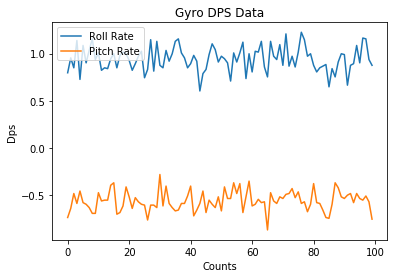

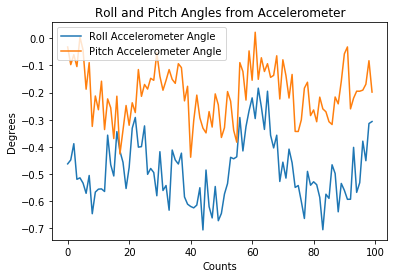

In [60]:
import matplotlib.pyplot as plt
import numpy as np

RAD_TO_DEG = 180./np.pi

def packRawGyroData():
    return [Nav_Gyro_GetData(0x01), Nav_Gyro_GetData(0x02), 
            Nav_Gyro_GetData(0x03)]

def packRawAccData():
    return [Nav_Acc_GetData(0x01), Nav_Acc_GetData(0x02), 
            Nav_Acc_GetData(0x03)]

N = 100 # Number of iterations
GyroRawNavData = np.array([packRawGyroData() for _ in range(N)])
#print("Gyroscope Raw Data: \n", GyroRawNavData)
GyroDPSNavData = Gyro_gRangeLSB * GyroRawNavData
#print("Gyroscope DPS Data: \n", GyroDPSNavData)

# Might need to flip values i.e. multiply by (-1), decide based on testing and reference wanted
AccRawNavData = np.array([packRawAccData() for _ in range(N)])
#print("Accelerometer Raw Data: \n", AccRawNavData)
AccGNavData = Accel_xlRangeLSB * AccRawNavData
#print("Accelerometer G Data: \n", AccGNavData)

plt.figure()
plt.plot(GyroDPSNavData[:, 0], label = 'Roll Rate')
plt.plot(GyroDPSNavData[:, 1], label = 'Pitch Rate')
#plt.plot(GyroDPSNavData[:, 2], label = 'Yaw Rate')
plt.ylabel('Dps')
plt.xlabel('Counts')
plt.title('Gyro DPS Data')
plt.legend(loc=2)

# Convert Accelerometer values to degrees
rollAccAngle = np.arctan2(AccRawNavData[:,1], AccRawNavData[:,2] + np.pi) * RAD_TO_DEG
pitchAccAngle = np.arctan2(AccRawNavData[:,0], AccRawNavData[:,2] + np.pi) * RAD_TO_DEG

plt.figure()
plt.plot(rollAccAngle, label = 'Roll Accelerometer Angle')
plt.plot(pitchAccAngle, label = 'Pitch Accelerometer Angle')
plt.ylabel('Degrees')
plt.xlabel('Counts')
plt.title('Roll and Pitch Angles from Accelerometer')
plt.legend(loc=2)

### Testing Sensor with Kalman

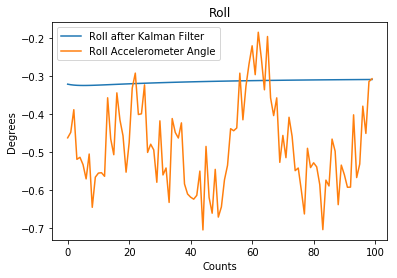

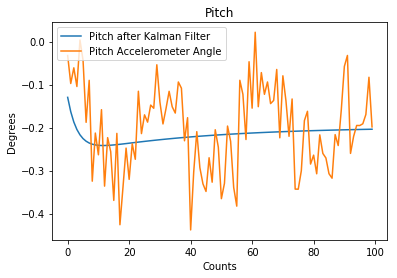

In [61]:
kalmanXAngle = KalmanFilter()
kalmanYAngle = KalmanFilter()

for roll, rollRate in zip(rollAccAngle, GyroDPSNavData[:, 0]):
    phi_Kdata = np.array([kalmanXAngle.update(roll,rollRate) for _ in range(N)])
for pitch, pitchRate in zip(pitchAccAngle, GyroDPSNavData[:,1]):
    theta_Kdata = np.array([kalmanYAngle.update(pitch,pitchRate) for _ in range(N)])
           
# plot Roll Angle
plt.figure()
plt.plot(phi_Kdata,label='Roll after Kalman Filter')
plt.plot(rollAccAngle, label = 'Roll Accelerometer Angle')
plt.ylabel('Degrees')
plt.xlabel('Counts')
plt.title('Roll')
plt.legend(loc=2)

# plot Pitch Angle
plt.figure()
plt.plot(theta_Kdata,label='Pitch after Kalman Filter')
plt.plot(pitchAccAngle, label = 'Pitch Accelerometer Angle')
plt.ylabel('Degrees')
plt.xlabel('Counts')
plt.title('Pitch')
plt.legend(loc=2)

### Complementary Filter

In [63]:
class ComplementaryFilter(object):
    def __init__(self, currAngle = 0):
        self.currAngle = currAngle

    def update(self, accAngle, gyroRate):
        AA = 0.98
        CAngle = AA*(self.currAngle + gyroRate*DT) + (1-AA)*accAngle
        self.currAngle = CAngle
        
        return self.currAngle

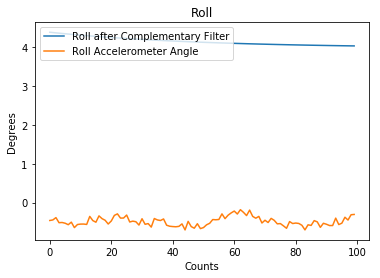

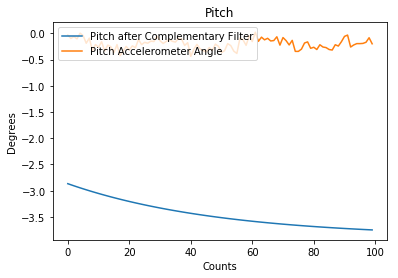

In [65]:
compXAngle = ComplementaryFilter()
compYAngle = ComplementaryFilter()

for roll, rollRate in zip(rollAccAngle, GyroDPSNavData[:, 0]):
    phi_Cdata = np.array([compXAngle.update(roll,rollRate) for _ in range(N)])
for pitch, pitchRate in zip(pitchAccAngle, GyroDPSNavData[:,1]):
    theta_Cdata = np.array([compYAngle.update(pitch,pitchRate) for _ in range(N)])

# plot Roll Angle
plt.figure()
plt.plot(phi_Cdata,label='Roll after Complementary Filter')
plt.plot(rollAccAngle, label = 'Roll Accelerometer Angle')
plt.ylabel('Degrees')
plt.xlabel('Counts')
plt.title('Roll')
plt.legend(loc=2)

# plot Pitch Angle
plt.figure()
plt.plot(theta_Cdata,label='Pitch after Complementary Filter')
plt.plot(pitchAccAngle, label = 'Pitch Accelerometer Angle')
plt.ylabel('Degrees')
plt.xlabel('Counts')
plt.title('Pitch')
plt.legend(loc=2)

### Kalman v Complementary comparison plots

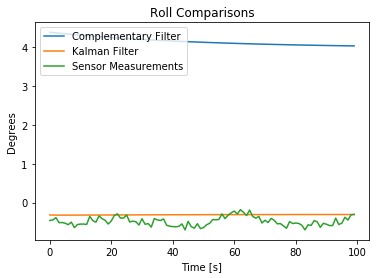

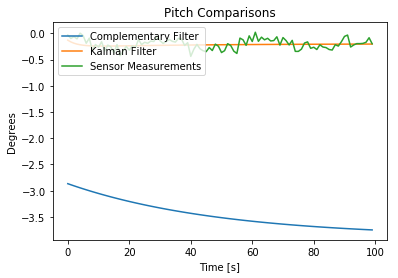

In [66]:
# plot Roll angle, roll is phi
plt.figure()
plt.plot(phi_Cdata,label='Complementary Filter')
plt.plot(phi_Kdata, label='Kalman Filter')
plt.plot(rollAccAngle, label='Sensor Measurements')
plt.ylabel('Degrees')
plt.xlabel('Time [s]')
plt.title('Roll Comparisons')
plt.legend(loc=2)

# plot Pitch angle, pitch is theta
plt.figure()
plt.plot(theta_Cdata,label='Complementary Filter')
plt.plot(theta_Kdata, label='Kalman Filter')
plt.plot(pitchAccAngle, label='Sensor Measurements')
plt.ylabel('Degrees')
plt.xlabel('Time [s]')
plt.title('Pitch Comparisons')
plt.legend(loc=2)

# DEBUG Code Only (still needs updating)

## Collecting Accelerometer single samples

In [17]:
Nav_Acc_Pwr(1)

acc_x_flip = -1
acc_y_flip = -1
acc_z_flip = -1

print(acc_x_flip*Nav_Acc_GetData(0x01), ' ', acc_y_flip*Nav_Acc_GetData(0x02), ' ', acc_z_flip*Nav_Acc_GetData(0x03))

2268   399   -15965


## Collecting Altimeter samples

In [ ]:
alt_gyro_start = Nav_Alt_Pwr(1)

T_SAMPLE = 30
FS = 2
N_SAMPLE = T_SAMPLE*FS

for x in range(0, N_SAMPLE):
    alt_raw = Nav_Alt_GetData()
    print('Alt Raw: ', alt_raw)
    
    time.sleep(1/FS)

## Getting raw gyro data and converting to dps

In [23]:
# Turning on gyro
Nav_Acc_Gyro_Pwr(1)

GYRO_RAW = list()
GYRO_DPS = list()
gRangeLSB = 0.00875

T_SAMPLE = 30
FS = 2
N_SAMPLE = T_SAMPLE*FS

for x in range(0, N_SAMPLE):
    acc_gyro_data_x = Nav_Gyro_GetData(0x01)
    acc_gyro_data_y = Nav_Gyro_GetData(0x02)
    acc_gyro_data_z = Nav_Gyro_GetData(0x03)
    
    GYRO_RAW.append(acc_gyro_data_x)
    GYRO_RAW.append(acc_gyro_data_y)
    GYRO_RAW.append(acc_gyro_data_z)
    
    GX_dps = acc_gyro_data_x * gRangeLSB
    GY_dps = acc_gyro_data_y * gRangeLSB
    GZ_dps = acc_gyro_data_z * gRangeLSB
    
    GYRO_DPS.append(GX_dps)
    GYRO_DPS.append(GY_dps)
    GYRO_DPS.append(GZ_dps)
    
    print("GYRO_RAW:", GYRO_RAW[(x*3) + 0], "\t", GYRO_RAW[(x*3) + 1], "\t", GYRO_RAW[(x*3) + 2], "\r\n")
    print("GYRO_DPS:", GYRO_DPS[(x*3) + 0], "\t", GYRO_DPS[(x*3) + 1], "\t", GYRO_DPS[(x*3) + 2], "\r\n")
    
    time.sleep(1/FS)

GYRO_RAW: 115 	 -48 	 136 

GYRO_DPS: 1.00625 	 -0.42000000000000004 	 1.1900000000000002 

GYRO_RAW: 112 	 -50 	 137 

GYRO_DPS: 0.9800000000000001 	 -0.43750000000000006 	 1.1987500000000002 

GYRO_RAW: 129 	 -52 	 139 

GYRO_DPS: 1.1287500000000001 	 -0.45500000000000007 	 1.21625 

GYRO_RAW: 116 	 -50 	 140 

GYRO_DPS: 1.0150000000000001 	 -0.43750000000000006 	 1.225 

GYRO_RAW: 122 	 -43 	 141 

GYRO_DPS: 1.0675000000000001 	 -0.37625000000000003 	 1.2337500000000001 

GYRO_RAW: 112 	 215 	 130 

GYRO_DPS: 0.9800000000000001 	 1.88125 	 1.1375000000000002 

GYRO_RAW: -295 	 12337 	 232 

GYRO_DPS: -2.5812500000000003 	 107.94875 	 2.0300000000000002 

GYRO_RAW: -159 	 1521 	 63 

GYRO_DPS: -1.39125 	 13.308750000000002 	 0.55125 

GYRO_RAW: 144 	 -217 	 136 

GYRO_DPS: 1.2600000000000002 	 -1.8987500000000002 	 1.1900000000000002 

GYRO_RAW: 128 	 -68 	 137 

GYRO_DPS: 1.12 	 -0.5950000000000001 	 1.1987500000000002 

GYRO_RAW: 80 	 21 	 131 

GYRO_DPS: 0.7000000000000001 	 0.183

## Collecting acc and gyro data

In [28]:
Nav_Acc_Gyro_Pwr(1)
Nav_Acc_Pwr(1)

ACC = list()
GYRO = list()

gRangeLSB = 0.00875

# Gyro
GX = Nav_Gyro_GetData(0x01)
GY = Nav_Gyro_GetData(0x02)
GZ = Nav_Gyro_GetData(0x03)
#print(GX, ' ', GY, ' ', GZ)

GX_dps = GX * gRangeLSB
GY_dps = GY * gRangeLSB
GZ_dps = GZ * gRangeLSB
print('gyro dps: ', GX_dps, ' ', GY_dps, ' ', GZ_dps)

GYRO.append(GX_dps)
GYRO.append(GY_dps)
GYRO.append(GZ_dps)

m_GRangeLSB = 0.000061
acc_x_flip = -1
acc_y_flip = -1
acc_z_flip = 1

acc_x = acc_x_flip*Nav_Acc_GetData(0x01)*m_GRangeLSB
acc_y = acc_y_flip*Nav_Acc_GetData(0x02)*m_GRangeLSB
acc_z = acc_z_flip*Nav_Acc_GetData(0x03)*m_GRangeLSB

print('acc G (x,y,x): %.2f, %.2f, %.2f' % (acc_x,acc_y,acc_z))

ACC.append(acc_x);
ACC.append(acc_y);
ACC.append(acc_z);

gyro dps:  1.3125000000000002   -0.5337500000000001   1.26875
acc G (x,y,x): -0.95, -0.02, -0.17


## Saving data to a *.txt file

In [42]:
Nav_Acc_Pwr(1)
Nav_Acc_Gyro_Pwr(1)

NUM_SAMPLE = 300

acc_x_flip = 1
acc_y_flip = 1
acc_z_flip = 1

#Calibration offset for GYRO
#129.258240,-50.149078,135.703751

gyro_offset_x = -129
gyro_offset_y = 50
gyro_offset_z = -135

gyro_x_flip = 1 # Need to determine positive roll rotation,   WANT: CCW-, CW +
gyro_y_flip = 1 # Need to determine positive pitch rotation; CCW -, CW +
gyro_z_flip = 1 # TO-DO: Calculation for yaw

#my_file = open("cal_data_acc_gryo_stationary.txt", "w")
my_file = open("cal_data_acc_gryo.txt", "w")
for i in range(0,NUM_SAMPLE):
    acc_get_data_x = acc_x_flip*Nav_Acc_GetData(0x01)
    acc_get_data_y = acc_y_flip*Nav_Acc_GetData(0x02)
    acc_get_data_z = acc_z_flip*Nav_Acc_GetData(0x03)
    
    acc_gyro_data_x = gyro_x_flip*(Nav_Gyro_GetData(0x01) + gyro_offset_x)
    acc_gyro_data_y = gyro_y_flip*(Nav_Gyro_GetData(0x02) + gyro_offset_y)
    acc_gyro_data_z = gyro_z_flip*(Nav_Gyro_GetData(0x03) + gyro_offset_z)
    
    #my_file.write('ACC: \t')
    my_file.write(str(i))
    my_file.write(' ')
    my_file.write(str(acc_get_data_x))
    my_file.write(' ')
    my_file.write(str(acc_get_data_y))
    my_file.write(' ')
    my_file.write(str(acc_get_data_z))
    my_file.write(' ')
    
    #my_file.write('GYRO RAW: \t')
    my_file.write(str(acc_gyro_data_x))
    my_file.write(' ')
    my_file.write(str(acc_gyro_data_y))
    my_file.write(' ')
    my_file.write(str(acc_gyro_data_z))
    my_file.write('\n')
    time.sleep(1/10)
my_file.close()

#my_file = open("cal_data_acc.txt", "w")
#for i in range(0,1000):
#    acc_get_data_x = Nav_Acc_GetData(1)
#    acc_get_data_y = Nav_Acc_GetData(2)
#    acc_get_data_z = Nav_Acc_GetData(3)
#    my_file.write('ACC \n')
#    my_file.write(str(acc_get_data_x))
#    my_file.write('\n')
#    my_file.write(str(acc_get_data_y))
#    my_file.write('\n')
#    my_file.write(str(acc_get_data_z))
#    my_file.write("\n \n")
#my_file.close()
#gRangeLSB = 0.00875
#my_file = open("cal_data_gyro.txt", "w")
#for i in range(0,60):
#    acc_gyro_data_x = Nav_Gyro_GetData(0x01)*gRangeLSB
#    acc_gyro_data_y = Nav_Gyro_GetData(0x02)*gRangeLSB
#    acc_gyro_data_z = Nav_Gyro_GetData(0x03)*gRangeLSB
#    my_file.write('GYRO DPS: \n')
#    my_file.write(str(acc_gyro_data_x))
#    my_file.write('\n')
#    my_file.write(str(acc_gyro_data_y))
#    my_file.write('\n')
#    my_file.write(str(acc_gyro_data_z))
#    my_file.write('\n \n')
#    time.sleep(1/2)
#my_file.close()    
#my_file = open("cal_data_gyro_raw.txt", "w")
#for i in range(0,60):
#    acc_gyro_data_x = Nav_Gyro_GetData(0x01)
#    acc_gyro_data_y = Nav_Gyro_GetData(0x02)
#    acc_gyro_data_z = Nav_Gyro_GetData(0x03)
#    my_file.write('GYRO RAW: \n')
#    my_file.write(str(acc_gyro_data_x))
#    my_file.write('\n')
#    my_file.write(str(acc_gyro_data_y))
#    my_file.write('\n')
#    my_file.write(str(acc_gyro_data_z))
#    my_file.write('\n \n')
#    time.sleep(1/2)
#my_file.close()
#my_file = open("cal_data_mag.txt", "w")    
#for i in range(0,1000):
#    mag_data_x = Nav_Mag_GetData(1)
#    mag_data_y= Nav_Mag_GetData(2)
#    mag_data_z= Nav_Mag_GetData(3)
#    my_file.write('MAG \n')
#    my_file.write(str(mag_data_x))
#    my_file.write('\n')
#    my_file.write(str(mag_data_y))
#    my_file.write('\n')
#    my_file.write(str(mag_data_z))
#    my_file.write('\n \n')
#my_file.close()

## Determining Calibration

In [ ]:
#TO-DO
if(( 400 <= mag_z < 30000))
    bool right = TRUE 
if((mag_x < && mag_x >=))
    bool back = TRUE
if((mag_x <  && mag_x >=))
    bool front = TRUE
if(mag_x < )
    bool left = TRUE
if(mag_z >= && mag_z < )
   bool forward = TRUE
if(mag_z < )
   bool backward = TRUE

if(forward && right)
   bool correct_backward = TRUE
   bool correct_left = TRUE
if(backward && right)
   bool correct_forward = TRUE
   bool correct_left = TRUE
if(forward && left)
   bool correct_backward = TRUE
   bool correct_right = TRUE
if(backward && left)
   bool correct_forward = TRUE
   bool correct_right = TRUE
